In [1]:
# TODO
# Change `if ROI not in []' to instead be `for index, row in Sauthoff...` from that lake onwards
# Bring in code to look at Slessor 4+5 as one lake
# Make plotting and saving time series fig separate functions 
# so that not every polygon removal plot is saved, just the last one
# Fix plot_evolving_outlines_dArea
# Make plot_evolving_outlines_dArea_dHeight_dVol
# Later: figs: show limit of SARIn coverage
# For find_evolving_outlines func plotting title and saving fig: 
# fix date type mismatch between CS2 and IS2; perhaps change CS2 to be np.datetime64?
# Incorporate volume change estimates from KambIS_Horgan notebook
# Investigate the code below, is it calculating area properly?
                        # # Calc polygon area and perimeter and store to lists
                        # lon, lat = XY_TO_LL.transform(x,y)
                        # poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                        # poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                        # areas += [poly_area]
                        # perims += [poly_perim]
                        # datetimes += [midcyc_date]

# Computing environment setup

# Set up computing environment

In [2]:
# %pip install import cv2

In [3]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Code to create fig. X in Sauthoff and others, 2023
#
# Written 2023-09-06 by W. Sauthoff (sauthoff@mines.edu)

# Import packages
# import cv2
import datetime
import earthaccess
import math
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors 
import matplotlib.dates as mdates
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import openpyxl
from pathlib import Path
from pyproj import CRS, Transformer
import os
import rioxarray
from skimage import measure
import warnings
import xarray as xr

# Suppress all warnings
warnings.filterwarnings("ignore")
# Ignore warning about missing/empty geometries
# warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# Reset warnings to default (optional)
# warnings.resetwarnings()

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    # DATA_DIR = '/home/jovyan/data_dir'
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/figX_subglacial_lake_areas'
    SCRIPT_DIR = '/home/jovyan/repos/scripts'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Users/Wilson/Documents/data'
    # DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'
    OUTPUT_DIR = '/Users/Wilson/Documents/0-code/1_outlines_candidates/output/figX_subglacial_lake_areas'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer

# Define utility functions
def datetime2fracyear(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    Inputs
    * lon, lat in decimal degrees (lon: W is negative; lat: S is negative)
    Outputs
    * x, y polar stereographic 71 in m
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

# Change default font to Arial and increase font size
# plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 20})
# plt.rcParams["font.family"] = 'sans-serif' # set back to default

# Import datasets

In [5]:
CS2_dh = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2021.5.nc')
CS2_dh

<xarray.Dataset>
Dimensions:      (y: 4451, x: 5451, time: 45)
Coordinates:
  * y            (y) float64 2.265e+06 2.264e+06 ... -2.184e+06 -2.185e+06
  * x            (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time         (time) float64 2.01e+03 2.011e+03 ... 2.021e+03 2.022e+03
Data variables:
    mask         (y, x) float64 ...
    delta_h      (time, y, x) float64 ...
    count        (time, y, x) float64 ...
    spatial_ref  int64 ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [6]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [7]:
# Find ICESat-2 ATL15 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 16


In [8]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)

Opening 16 granules, approx size: 5.05 GB


QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
files

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [10]:
# After viewing files, index the files you wish to open
print(files[15])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [11]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[15], group='delta_h')
ATL15_A2 = xr.open_dataset(files[9], group='delta_h')
ATL15_A3 = xr.open_dataset(files[8], group='delta_h')
ATL15_A4 = xr.open_dataset(files[10], group='delta_h')

In [12]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [13]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [14]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [15]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15 = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [16]:
# Add an attribute that will be used to identify the dataset
ATL15.attrs['identifier_product_DOI'] = '10.5067/ATLAS/ATL15.003'

In [17]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [18]:
# Import subglacial lake outline inventories
# exec(open(SCRIPT_DIR + '/Smith2009_outlines.py').read())
# exec(open(SCRIPT_DIR + '/SiegfriedFricker2018_outlines.py').read())
# Will earlier two inventories load using the 2023 py script
exec(open(SCRIPT_DIR + '/Sauthoff2023_outlines.py').read())

In [19]:
# Import MODIS MOA 2009 and 2014 coastline and grounding line for plotting inset maps
# https://nsidc.org/data/nsidc-0593/versions/1
# shp = DATA_DIR + '/boundaries/MODIS_MOA/2009/moa_2009_coastline_v02.0.shp' 
# moa_2009_coastline = gpd.read_file(shp)
# shp = DATA_DIR + '/boundaries/MODIS_MOA/2009/moa_2009_groundingline_v02.0.shp' 
# moa_2009_groundingline = gpd.read_file(shp)
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)

In [20]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [21]:
# Clip altimetry datasets to grounding line to limit analysis to only below grounded ice
CS2_dh.rio.write_crs(3031, inplace=True)
CS2_dh_clipped = CS2_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)
ATL15.rio.write_crs("epsg:3031", inplace=True)
ATL15 = ATL15.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

# Functions

The following functions enable a workflow to define region of interest, find evolving contours of delta height, plot results, refine those results to manually remove signal that is likely not related to subglacial lake activity, and export the evolving outlines and delta area time series.
* func for finding bbox coords for region of interest
* func to make directories to store output of latter func's
* func for contouring creating plots for each differenced time slice including saving plots and a gdf of the evolving outlines
* func to plot evolving outlines in aggregate
* func to remove non-overlapping outlines
* func to remove most extreme polygon to clean up outlines that are off-lake
* func to take modified gdf and calculated delta area per time slice and export as csv
* func to plot evolving outlines in aggregate and the dVol time series

In [22]:
def find_bbox_coords(ROI, buffer):
    '''
    Func to find the bounding box coordinates of a region of interest
    
    Inputs
    * ROI: Region of interest in form of 
    1) a lake name from Sauthoff and others, 2024 inventory (Sauthoff2024_outlines),
    2) IMBIE basin or refinded basins, 
    3) x and y values of a single point of interest, 
    4) or list of x_min, x_max, y_min, y_max bbox coords
    * buffer: horizontal distance in meters that will be added to each edge of the ROI to include in the bbox
    
    Outputs:
    * x_min, x_max, y_min, y_max bbox coords
    '''
    if Sauthoff2023_outlines['name'].str.contains(ROI).any():
        # Isolate individual lake using gpd buffer
        lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == ROI]  
        lake_gpd
        lake_buffer = lake_gpd.buffer(buffer)
        # Define lake bounding box
        x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
        y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
     
    elif IMBIE_basins['NAME'].str.contains(ROI).any():
        # Isolate individual basin as geodf
        basin = IMBIE_basins[IMBIE_basins['NAME'] == ROI]

        # Define region bounding box
        x_min = basin.geometry.bounds.minx.values[0]; x_max = basin.geometry.bounds.maxx.values[0]
        y_min = basin.geometry.bounds.miny.values[0]; y_max = basin.geometry.bounds.maxy.values[0]
        
    elif len(ROI)==2:
        x_min = ROI[0]-buffer; x_max = ROI[0]+buffer
        y_min = ROI[1]-buffer; y_max = ROI[1]+buffer     
    
    elif len(ROI)==4: 
        x_min = ROI[0]; x_max = ROI[1]
        y_min = ROI[2]; y_max = ROI[3]
        
    return x_min, x_max, y_min, y_max

In [23]:
# def find_bbox_coords_n_clip(ROI, buffer, dataset1, dataset2):
#     '''
#     Func to find the bounding box coordinates of a region of interest
    
#     Inputs
#     * ROI: Region of interest in form of 
#     1) a lake name from Sauthoff and others, 2024 inventory (Sauthoff2024_outlines),
#     2) IMBIE basin or refinded basins, 
#     3) x and y values of a single point of interest, 
#     4) or list of x_min, x_max, y_min, y_max bbox coords
#     * buffer: horizontal distance in meters that will be added to each edge of the ROI to include in the bbox
    
#     Outputs:
#     * x_min, x_max, y_min, y_max bbox coords
#     * datasets clipped to ROI
#     '''
#     if Sauthoff2023_outlines['name'].str.contains(ROI).any():
#         # Isolate individual lake using gpd buffer
#         lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == ROI]  
#         lake_gpd
#         lake_buffer = lake_gpd.buffer(buffer)
#         # Define lake bounding box
#         x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
#         y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
        
#         # # Clip dataset to region of interest
#         # ds1_clipped_{}.format(ROI) = dataset1.where(mask_x & mask_y, drop=True)
#         # ds2_clipped_{}.format(ROI) = dataset2.where(mask_x & mask_y, drop=True)
 
#     elif IMBIE_basins['NAME'].str.contains(ROI).any():
#         # Isolate individual basin as geodf
#         basin = IMBIE_basins[IMBIE_basins['NAME'] == ROI]

#         # Define region bounding box
#         x_min = basin.geometry.bounds.minx.values[0]; x_max = basin.geometry.bounds.maxx.values[0]
#         y_min = basin.geometry.bounds.miny.values[0]; y_max = basin.geometry.bounds.maxy.values[0]
        
#         # Clip dataset to IMBIE basin of interest
#         ds1_clipped = dataset.rio.clip(basin.geometry.values, basin.crs)
#         ds2_clipped = dataset.rio.clip(basin.geometry.values, basin.crs)

#     elif len(ROI)==2:
#         x_min = ROI[0]-buffer; x_max = ROI[0]+buffer
#         y_min = ROI[1]-buffer; y_max = ROI[1]+buffer     
    
#     elif len(ROI)==4: 
#         x_min = ROI[0]; x_max = ROI[1]
#         y_min = ROI[2]; y_max = ROI[3]
        
#     return x_min, x_max, y_min, y_max

In [24]:
def make_dirs(func_name):
    '''
    Make appropriate directories if they don't already exist and
    create Path objects for the given file paths
    
    Inputs
    * func name (str) for where you'd like to store output and
    store the Path objects
    
    Outputs
    * tuple: A tuple containing two Path objects representing the file paths.
    '''
    png_path = OUTPUT_DIR + '/{}/png'.format(func_name)
    avi_path = OUTPUT_DIR + '/{}/avi'.format(func_name)
    paths = [png_path, avi_path]
    for i in paths: 
        if not os.path.exists(i):
            os.makedirs(i)

    return Path(png_path), Path(avi_path)

# Example usage
# (png_path, avi_path) = make_dirs_file_paths('find_evolving_contours')

In [25]:
def create_dirs(folder_names, base_directory='.'):
    '''
    Make appropriate directories if they don't already exist and
    
    Inputs
    * folder names as list
    * base directory to put new folders
    
    Outputs
    * makes directories if they don't already exist
    '''
    for folder_name in folder_names:
        folder_path = os.path.join(base_directory, folder_name)

        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created at '{folder_path}'")
        except FileExistsError:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'")

# # Example usage:
# folder_list = ['Folder1', 'Folder2', 'Folder3']
# create_folders(folder_list)

In [26]:
def create_ROI_dirs(base_directory='.'):
    '''
    Make appropriate directories if they don't already exist and
    
    Inputs
    * base directory to put new folders
    
    Outputs
    * makes directories if they don't already exist
    '''
    for i in Sauthoff2023_outlines['name']:
        folder_name = str(i)
        folder_path = base_directory + '/' + folder_name

        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created at '{folder_path}'")
        except FileExistsError:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'")
            
    # IMBIE basins
            
# Example usage
# make_ROI_dirs(base_directory='.')

In [27]:
def find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
    
    Inputs: 
    * x_min, x_max, y_min, y_max: polar stereographic coords
    * threshold: vertical distance in meters to delineate ice surface deformation contour
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
    deformation contours plotted to delineate evolving lake boundaries.
    * geopandas geodataframe of polygons created at each step (would need to modify to collect all polygons 
    at all time steps)
    '''

    # Subset CryoSat-2 SARIn data set to region of interest
    mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    ds1_clipped = dataset1.where(mask_x & mask_y, drop=True)
    
    # Subset ATL15 data set to region of interest
    mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
    mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
    ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)
    ds2_clipped = ds2_clipped.isel(y=slice(None, None, -1))

    # Create lines for legend
    uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
            
    # Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
    cyc_start_dates = []
    cyc_end_dates = []
    midcyc_dates = []
    for idx in range(len(dataset1.delta_h[:33])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product
        # ASSUMES THE SAME DATASET LENGTH, WHICH MIGHT NOT BE TRUE
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
    for idx in range(len(dataset2.delta_h)-1): 
        # ICESat-2 ATL15 r003
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        midcyc_date = pd.to_datetime(midcyc_date)
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)): 
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            dhdt = ds1_clipped.delta_h[idx+1,:,:]-ds1_clipped.delta_h[idx,:,:]
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcyc_date = midcyc_dates[idx]
        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over with new dataset
            dhdt = ds2_clipped.delta_h[(idx-33)+1,:,:]-ds2_clipped.delta_h[(idx-33),:,:]
            # dhdt = np.flipud(dhdt)
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcyc_date = midcyc_dates[idx]

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
    
        if np.any(~np.isnan(dhdt)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
                origin='upper', cmap='coolwarm_r', 
                norm=colors.CenteredNorm())

            # Create empty lists to store contours 
            contours_pos = []
            contours_neg = []

            # Create contours at the positive and negative threshold 
            contour = measure.find_contours(dhdt.values, threshold)
            # If at least one contour, add to list of contours
            if len(contour) > 0: 
                contours_pos += [contour]
            contour = measure.find_contours(dhdt.values, -threshold)
            if len(contour) > 0: 
                contours_neg += [contour]

            # Plot contours and make into polygons
            for i in range(len(contours_pos)): 
                for j in range(len(contours_pos[i])):
                    x = x_min+contours_pos[i][j][:,1]*x_conv
                    y = y_max-contours_pos[i][j][:,0]*y_conv
                    ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)

                    # Make polygons from variable outlines and store to list
                    if len(contours_pos[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y))) 
                        polys += [poly]

                        # Calc polygon area and perimeter and store to lists
                        lon, lat = XY_TO_LL.transform(x,y)
                        poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                        poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                        areas += [poly_area]
                        perims += [poly_perim]
                        datetimes += [midcyc_date]

            for i in range(len(contours_neg)): 
                for j in range(len(contours_neg[i])):
                    x = x_min+contours_neg[i][j][:,1]*x_conv
                    y = y_max-contours_neg[i][j][:,0]*y_conv
                    ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)

                    # Make polygons from variable outlines
                    if len(contours_neg[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        polys += [poly]

                        # Calc polygon area and perimeter and store to lists
                        lon, lat = XY_TO_LL.transform(x,y)
                        poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                        poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                        areas += [poly_area]
                        perims += [poly_perim]
                        datetimes += [midcyc_date]

            # Overlay published active lake outlines for visual comparison and grounding line
            S09_color = 'cyan'
            SF18_color  = 'darkcyan'
            S23_color = 'deepskyblue'
            Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
            Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
            SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
            SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
            Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
            Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)

            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [m]', size=15)
            ax.set_ylabel('y [m]', size=15) 
            ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
            # if idx <= 32:
            #     ax.set_title('dh between {} and {}'.format(cyc_start_date.date(), 
            #     cyc_end_date.date()), size=15)
            # elif idx > 32:
            #     ax.set_title('dh between {} and {}'.format(cyc_start_date.astype('datetime64[D]').astype(str), 
            #     cyc_end_date.astype('datetime64[D]').astype(str)), size=15)
            # Plot inset map
            axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)

            # Plot black rectangle to indicate location
            # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
            # axIns.add_artist(rect)

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
            axIns.axis('off')

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

            # Add legend
            ax.legend([uplift, subsidence],
                [('+ '+str(threshold)+' m uplift (filling) evolving outline'), 
                 ('– '+str(threshold)+' m subsidence (draining) evolving outline')], 
                loc='upper left')

            # Save and close fig
            # plt.savefig(OUTPUT_DIR + 
            #     '/find_evolving_outlines/png/{}/find_evolving_outlines{}_{}km-buffer_{}m-threshold_{}-{}.png'
            #     .format(ROI, ROI, buffer/1e3, threshold, cyc_start_date.date(), cyc_end_date.date()), dpi=300, bbox_inches='tight')
            plt.close()
    
    # # Create avi video from figs created of each differenced time slice
    # # Create video name
    # video_name = '/evolving_contours_{}_{}km-buffer_{}m-threshold.avi'.format(ROI, buffer/1e3, threshold)
    # # Store individual frames
    # images = [img for img in os.listdir(png_path) if img.endswith(".png")]
    # # Create frame dimension
    # frame = cv2.imread(os.path.join(png_path, images[0]))
    # height, width, layers = frame.shape
    # # VideoWriter object will create a frame 
    # video = cv2.VideoWriter(avi_path + video_name, 0, 1, (width,height))
    # for image in images:
    #     video.write(cv2.imread(os.path.join(png_path, image)))
    # # Close all the frames
    # cv2.destroyAllWindows()
    # # Release the video write object
    # video.release()

    # Store polygons in geopandas geodataframe for further analysis
    d = {'geometry': polys, 
         'evolving area (km^2)': areas, 
         'perim (km)': perims, 
         'datetime': datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['date'] = pd.to_datetime(gdf['datetime']).apply(lambda x: x.date())

    return gdf

# # Example usage
# gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)

In [28]:
# adding evolving outline dh and dvol
def find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
    
    Inputs: 
    * x_min, x_max, y_min, y_max: polar stereographic coords
    * threshold: vertical distance in meters to delineate ice surface deformation contour
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
    deformation contours plotted to delineate evolving lake boundaries.
    * geopandas geodataframe of polygons created at each step (would need to modify to collect all polygons 
    at all time steps)
    '''

    # Subset CryoSat-2 SARIn data set to region of interest
    mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    ds1_clipped = dataset1.where(mask_x & mask_y, drop=True)
    
    # Subset ATL15 data set to region of interest
    mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
    mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
    ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)
    ds2_clipped = ds2_clipped.isel(y=slice(None, None, -1))

    # Create lines for legend
    uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
            
    # Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
    cyc_start_dates = []
    cyc_end_dates = []
    midcyc_dates = []
    for idx in range(len(dataset1.delta_h[:33])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product
        # ASSUMES THE SAME DATASET LENGTH, WHICH MIGHT NOT BE TRUE
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
    for idx in range(len(dataset2.delta_h)-1): 
        # ICESat-2 ATL15 r003
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        midcyc_date = pd.to_datetime(midcyc_date)
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    dhs = []
    dvols =[]
    datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)): 
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            dhdt = ds1_clipped.delta_h[idx+1,:,:]-ds1_clipped.delta_h[idx,:,:]
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcyc_date = midcyc_dates[idx]
        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over with new dataset
            dhdt = ds2_clipped.delta_h[(idx-33)+1,:,:]-ds2_clipped.delta_h[(idx-33),:,:]
            # dhdt = np.flipud(dhdt)
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcyc_date = midcyc_dates[idx]

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
    
        if np.any(~np.isnan(dhdt)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
                origin='upper', cmap='coolwarm_r', 
                norm=colors.CenteredNorm())

            # Create empty lists to store contours 
            contours_pos = []
            contours_neg = []

            # Create contours at the positive and negative threshold 
            contour = measure.find_contours(dhdt.values, threshold)
            # If at least one contour, add to list of contours
            if len(contour) > 0: 
                contours_pos += [contour]
            contour = measure.find_contours(dhdt.values, -threshold)
            if len(contour) > 0: 
                contours_neg += [contour]

            # Plot contours and make into polygons
            for i in range(len(contours_pos)): 
                for j in range(len(contours_pos[i])):
                    x = x_min+contours_pos[i][j][:,1]*x_conv
                    y = y_max-contours_pos[i][j][:,0]*y_conv
                    ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)

                    # Make polygons from variable outlines and store to list
                    if len(contours_pos[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y))) 
                        polys += [poly]

                        # Calc polygon area and perimeter and store to lists
                        lon, lat = XY_TO_LL.transform(x,y)
                        poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                        poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                        dhdt.rio.write_crs("epsg:3031", inplace=True)
                        dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
                        poly_dh = np.nanmean(dhdt_clip)
                        poly_dvol = poly_dh*poly_area
                        areas += [poly_area]
                        perims += [poly_perim]
                        dhs += [poly_dh]
                        dvols += [poly_dvol]
                        datetimes += [midcyc_date]

            for i in range(len(contours_neg)): 
                for j in range(len(contours_neg[i])):
                    x = x_min+contours_neg[i][j][:,1]*x_conv
                    y = y_max-contours_neg[i][j][:,0]*y_conv
                    ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)

                    # Make polygons from variable outlines
                    if len(contours_neg[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        polys += [poly]

                        # Calc polygon area and perimeter and store to lists
                        lon, lat = XY_TO_LL.transform(x,y)
                        poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                        poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                        dhdt.rio.write_crs("epsg:3031", inplace=True)
                        dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
                        poly_dh = np.nanmean(dhdt_clip)
                        poly_dvol = poly_dh*poly_area
                        areas += [poly_area]
                        perims += [poly_perim]
                        dhs += [poly_dh]
                        dvols += [poly_dvol]
                        datetimes += [midcyc_date]
                        
            # Overlay published active lake outlines for visual comparison and grounding line
            S09_color = 'cyan'
            SF18_color  = 'darkcyan'
            S23_color = 'deepskyblue'
            Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
            Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
            SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
            SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
            Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
            Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)

            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [m]', size=15)
            ax.set_ylabel('y [m]', size=15) 
            ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
            # if idx <= 32:
            #     ax.set_title('dh between {} and {}'.format(cyc_start_date.date(), 
            #     cyc_end_date.date()), size=15)
            # elif idx > 32:
            #     ax.set_title('dh between {} and {}'.format(cyc_start_date.astype('datetime64[D]').astype(str), 
            #     cyc_end_date.astype('datetime64[D]').astype(str)), size=15)
            # Plot inset map
            axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)

            # Plot black rectangle to indicate location
            # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
            # axIns.add_artist(rect)

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
            axIns.axis('off')

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

            # Add legend
            ax.legend([uplift, subsidence],
                [('+ '+str(threshold)+' m uplift (filling) evolving outline'), 
                 ('– '+str(threshold)+' m subsidence (draining) evolving outline')], 
                loc='upper left')

            # Save and close fig
            # plt.savefig(OUTPUT_DIR + 
            #     '/find_evolving_outlines/png/{}/find_evolving_outlines{}_{}km-buffer_{}m-threshold_{}-{}.png'
            #     .format(ROI, ROI, buffer/1e3, threshold, cyc_start_date.date(), cyc_end_date.date()), dpi=300, bbox_inches='tight')
            plt.close()
    
    # # Create avi video from figs created of each differenced time slice
    # # Create video name
    # video_name = '/evolving_contours_{}_{}km-buffer_{}m-threshold.avi'.format(ROI, buffer/1e3, threshold)
    # # Store individual frames
    # images = [img for img in os.listdir(png_path) if img.endswith(".png")]
    # # Create frame dimension
    # frame = cv2.imread(os.path.join(png_path, images[0]))
    # height, width, layers = frame.shape
    # # VideoWriter object will create a frame 
    # video = cv2.VideoWriter(avi_path + video_name, 0, 1, (width,height))
    # for image in images:
    #     video.write(cv2.imread(os.path.join(png_path, image)))
    # # Close all the frames
    # cv2.destroyAllWindows()
    # # Release the video write object
    # video.release()

    # Store polygons in geopandas geodataframe for further analysis
    d = {'geometry': polys, 
         'area (km^2)': areas, 
         'perim (km)': perims,
         'dh (m)': dhs, 
         'vol (km^3)': dvols, 
         'datetime': datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['date'] = pd.to_datetime(gdf['datetime']).apply(lambda x: x.date())

    return gdf

# # Example usage
# gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)

In [29]:
def plot_evolving_outlines_time_series(gdf, dataset1, dataset2):
    '''
    Func to plot evolving outlines in aggregate
    '''
            
    # Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
    cyc_start_dates = []
    cyc_end_dates = []
    midcyc_dates = []
    for idx in range(len(dataset1.delta_h[:33])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product
        # ASSUMES THE SAME DATASET LENGTH, WHICH MIGHT NOT BE TRUE
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
    for idx in range(len(dataset2.delta_h)-1): 
        # ICESat-2 ATL15 r003
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        midcyc_date = pd.to_datetime(midcyc_date)
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]

    # create fig, ax
    fig, ax = plt.subplots(figsize=(15,15))

    # Set colormap and normalize to date values
    cmap = plt.get_cmap('plasma', len(midcyc_dates)-1)
    norm = plt.Normalize(datetime2fracyear(midcyc_dates[0]), datetime2fracyear(midcyc_dates[-1]))
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in midcyc_dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.9)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=25)

    # Add black background to see outlines better
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
    ax.add_artist(rect) 

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    S23_color = 'deepskyblue'
    Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)
    moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='w', linewidth=1)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(midcyc_dates[0:-1], 0):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime2fracyear(midcyc_dates[idx]))), linewidth=3)
        lines.append(line)
        if any(gdf[gdf['datetime'] == dt]): 
            gdf[gdf['datetime'] == dt].boundary.plot(ax=ax, 
                color=cmap(norm(datetime2fracyear(midcyc_dates[idx])))
                )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 10)), linewidth=3)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 5)), linewidth=3)
    
    # Create legend
    ax.legend(handles=[Smith2009, 
        SiegfriedFricker2018, 
        tuple(lines)], 
        labels=['static outline (Smith and others, 2009)',
            'static outline (Siegfried & Fricker, 2018)', 
            # 'evolving outline ({} m threshold)'.format(threshold)], 
            'evolving outline (this study)'], 
              handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
             loc='upper left')

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=150, zorder=3)
    # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    # axIns.add_artist(rect) 
    axIns.axis('off')

    plt.savefig(OUTPUT_DIR + '/plot_evolving_outlines_time_series/{}/plot_evolving_outlines_time_series_{}_{}km-buffer_{}m-threshold-{}outlines.png'
        .format(ROI, ROI, buffer/1e3, threshold, len(gdf)),
                dpi=300, bbox_inches='tight')

    # plt.close()

In [30]:
def find_overlapping_polygons(gdf):
    '''
    Func to separate overlapping and non-overlapping polygons
    stored in one geopandas geodataframe into two geopandas 
    geodataframes
    
    Inputs
    * geopandas geodataframe
    
    Outputs
    * two geopandas geodataframes, one with overlapping polygons,
    one with non-overlapping polygons
    '''
    overlapping = []
    non_overlapping = []
    for n, p in enumerate(list(gdf.geometry), 0):
        if any(p.overlaps(g) for g in list(gdf.geometry)):
            # Store the index from the original dataframe
            overlapping.append(n)
        if not any(p.overlaps(g) for g in list(gdf.geometry)):
            non_overlapping.append(n)

    # Create a new dataframes and reset their indexes
    gdf_overlapping = gdf.iloc[overlapping]  
    gdf_overlapping.reset_index(drop=True, inplace=True)
    gdf_non_overlapping = gdf.iloc[non_overlapping]
    gdf_non_overlapping.reset_index(drop=True, inplace=True)
    
    return gdf_overlapping

In [31]:
def remove_outlier_polygon(gdf, axis='x', max_or_min='max'):
    '''
    Func to remove outline outliers by removing a polygon
    with the most extreme x or y coordinates
    
    Inputs
    * geopandas geodataframe
    * axis indicates whether the x or y axis will 
    have its extreme polygon removed
    * max_or_min indicates whether the max or min centroid axis
    value will be removed
    
    Ouputs
    * geopandas geodataframe with one outline removed
    '''
    
    # Check if the GeoDataFrame is empty
    if gdf.empty:
        print("GeoDataFrame is empty. Nothing to remove.")
        return gdf
    
    # Choose the axis and max or min for extreme value
    if axis not in ['x', 'y']:
        raise ValueError("Invalid axis. Use 'x' or 'y'.")
    if max_or_min not in ['max', 'min']:
        raise ValueError("Invalid max_or_min. Use 'max' or 'min'.")

    # Calculate the centroid and extreme value
    if axis == 'x':
        if max_or_min == 'max':
            idx_to_remove = gdf.geometry.bounds['maxx'].idxmax()
        else:
            idx_to_remove = gdf.geometry.bounds['minx'].idxmin()
    else:
        if max_or_min == 'max':
            idx_to_remove = gdf.geometry.bounds['maxy'].idxmax()
        else:
            idx_to_remove = gdf.geometry.bounds['miny'].idxmin()

    # Remove the polygon with the specified polygon index to remove
    gdf_filtered = gdf.drop(idx_to_remove)

    print(f"Removed polygon with extreme {max_or_min} {axis}-value at index {idx_to_remove}.")

    return gdf_filtered

# Example usage:
# Assuming 'gdf' is your GeoDataFrame
# new_gdf = remove_extreme_polygon(gdf, axis='x', positive=True)

In [32]:
def csv_export(ROI, gdf):
    '''
    Func to take modified gdf and calculated delta area per time slice and export as csv
    '''
    if Sauthoff2023_outlines['name'].str.contains(ROI).any():
        # Isolate individual lake using gpd buffer
        lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == ROI]  
        gdf['static area (km^2)'] = np.divide(sum(lake_gpd.area), 1e6)
    gdf.to_csv(OUTPUT_DIR + '/csv_export/area_time_series_{}.csv'.format(ROI),
        columns=['date', 'static area (km^2)', 'evolving area (km^2)'])

In [33]:
def plot_evolving_outlines_dArea(ROI, gdf, dataset1, dataset2):
    '''
    Func to plot evolving outlines in aggregate and the dArea time series
    '''
    # lake_S09 = Smith2009_outlines[(Smith2009_outlines['Name'] == 'Whillans_7')]
    # S09_color = 'lightseagreen'

    fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(15,5))

    # Plot 0 - plot evolving outlines

    # Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
    cyc_start_dates = []
    cyc_end_dates = []
    midcyc_dates = []
    for idx in range(len(dataset1.delta_h[:33])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product
        # ASSUMES THE SAME DATASET LENGTH, WHICH MIGHT NOT BE TRUE
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
    for idx in range(len(dataset2.delta_h)-1): 
        # ICESat-2 ATL15 r003
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        midcyc_date = pd.to_datetime(midcyc_date)
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]

    # Set colormap and normalize to date values
    cmap = plt.get_cmap('plasma', len(midcyc_dates)-1)
    norm = plt.Normalize(datetime2fracyear(midcyc_dates[0]), datetime2fracyear(midcyc_dates[-1]))
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in midcyc_dates[0:-1]]))
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.9)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=25)

    # Add black background to see outlines better
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
    ax.add_artist(rect) 

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    S23_color = 'deepskyblue'
    Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)
    moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='w', linewidth=1)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(midcyc_dates[0:-1], 0):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime2fracyear(midcyc_dates[idx]))), linewidth=3)
        lines.append(line)
        gdf[gdf['datetime'] == dt].boundary.plot(ax=ax, 
            color=cmap(norm(datetime2fracyear(midcyc_dates[idx])))
            )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 10)), linewidth=3)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 5)), linewidth=3)
    
    # Create legend
    ax.legend(handles=[Smith2009, 
        SiegfriedFricker2018, 
        tuple(lines)], 
        labels=['Smith and others, 2009 static outline',
            'Siegfried & Fricker, 2018 outline', 
            'evolving outline ({} m threshold)'.format(threshold)], handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    axIns.add_artist(rect) 
    axIns.axis('off')

    # Plot 1 - plot area change time series
    axs[1].axhline(np.divide(sum(lake_S09.area), 1e6), color=S09_color, linestyle=(0, (1, 4)))
    axs[1].plot(dates_unique, areas_evolving, color='k', linestyle=(0, (1, 1)))
    locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    axs[1].xaxis.set_major_locator(locator)
    axs[1].xaxis.set_major_formatter(formatter)
    min_area = min(np.divide(sum(lake_S09.area), 1e6), 
                    # np.divide(sum(lake_SF18.area), 1e6), 
                    min(areas_evolving))
    max_area = max(np.divide(sum(lake_S09.area), 1e6), 
                    # np.divide(sum(lake_SF18.area), 1e6), 
                    max(areas_evolving))
    axs[1].set(ylim=((min_area - (max_area - min_area)*0.05), (max_area + (max_area - min_area)*0.05)),
        xlim=(midcyc_dates[0], midcyc_dates[-1]))
    axs[1].set_ylabel('lake area [km$^2$]', size=17.5, labelpad=4)
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position("right")
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 4)), linewidth=3)
    evolving_outlines = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=3)
    legend2 = axs[1].legend([Smith2009,
        #SiegfriedFricker2018,
        evolving_outlines],
                    ['static outline',
        #'Siegfried & Fricker, 2018 static outline',
        # '±{} m variable outlines'.format(thres)], 
        'evolving outlines'],
        loc='upper right')
    legend2.get_frame().set_linewidth(0.0)
    axs[1].patch.set_alpha(1)
    
    plt.show()

In [34]:
def calculate_cumulative_area_by_date(gdf):
    # Ensure that the date column is in the correct format (datetime)
    gdf['date'] = pd.to_datetime(gdf['date'])

    # Calculate area for each polygon
    gdf['area'] = gdf['geometry'].area

    # Initialize a dictionary to store the cumulative area for each date
    cumulative_areas = {}

    # Loop through each unique date
    for date in gdf['date'].unique():
        # Filter rows for the current date
        matching_rows = gdf[gdf['date'] == date]

        # Sum the areas of the filtered rows
        cumulative_area = matching_rows['area'].sum()

        # Store the cumulative area in the dictionary
        cumulative_areas[date] = cumulative_area

    return cumulative_areas

In [35]:
def calculate_cumulative_metrics_by_date_to_gdf(gdf):
    # Ensure that the date column is in the correct format (datetime)
    gdf['date'] = pd.to_datetime(gdf['date'])

    # Initialize a list to store date and cumulative metrics
    data = []

    # Loop through each unique date
    for date in gdf['date'].unique():
        # Filter rows for the current date
        matching_rows = gdf[gdf['date'] == date]

        # Sum the areas of the filtered rows
        cumulative_area = matching_rows['area (km^2)'].sum()

        # Sum the dvols of the filtered rows
        cumulative_dvol = matching_rows['vol (km^3)'].sum()

        # Calculate the weighted sum of dhs
        weighted_dh_sum = (matching_rows['dh (m)'] * matching_rows['area (km^2)']).sum()
        total_area = matching_rows['area (km^2)'].sum()
        weighted_cumulative_dh = weighted_dh_sum / total_area if total_area != 0 else 0

        # Combine polygons into a multipolygon
        combined_polygon = MultiPolygon(matching_rows['geometry'].tolist())

        # Append to the data list
        data.append({
            'date': date, 
            'cumulative_area': cumulative_area,
            'cumulative_dvol': cumulative_dvol,
            'weighted_cumulative_dh': weighted_cumulative_dh,
            'combined_polygon': combined_polygon
        })

    # Create a new DataFrame from the data list
    new_df = pd.DataFrame(data)

    # Convert the new DataFrame to a GeoDataFrame
    new_gdf = gpd.GeoDataFrame(new_df, geometry='combined_polygon')

    return new_gdf

# Analysis

In [ ]:
create_dirs(['find_evolving_outlines/png'], OUTPUT_DIR)

In [ ]:
create_ROI_dirs(OUTPUT_DIR + '/find_evolving_outlines/png')

In [ ]:
create_dirs(['plot_evolving_outlines_time_series'], OUTPUT_DIR)

In [ ]:
create_ROI_dirs(OUTPUT_DIR + '/plot_evolving_outlines_time_series/')

In [40]:
ROI = 'Whillans_7'
buffer = 5000

x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

# Manually set bbox coords because of new lobe on Whillans7
x_min = -560e3; x_max = -525e3
y_min = -512e3; y_max = -494e3

In [36]:
ROI = 'ConwaySubglacialLake'
buffer = 5000

x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)
print(x_min)
print(x_max)
print(y_min)
print(y_max)

-337325.03066177026
-300074.97900256084
-534175.0474433429
-506299.95538391423


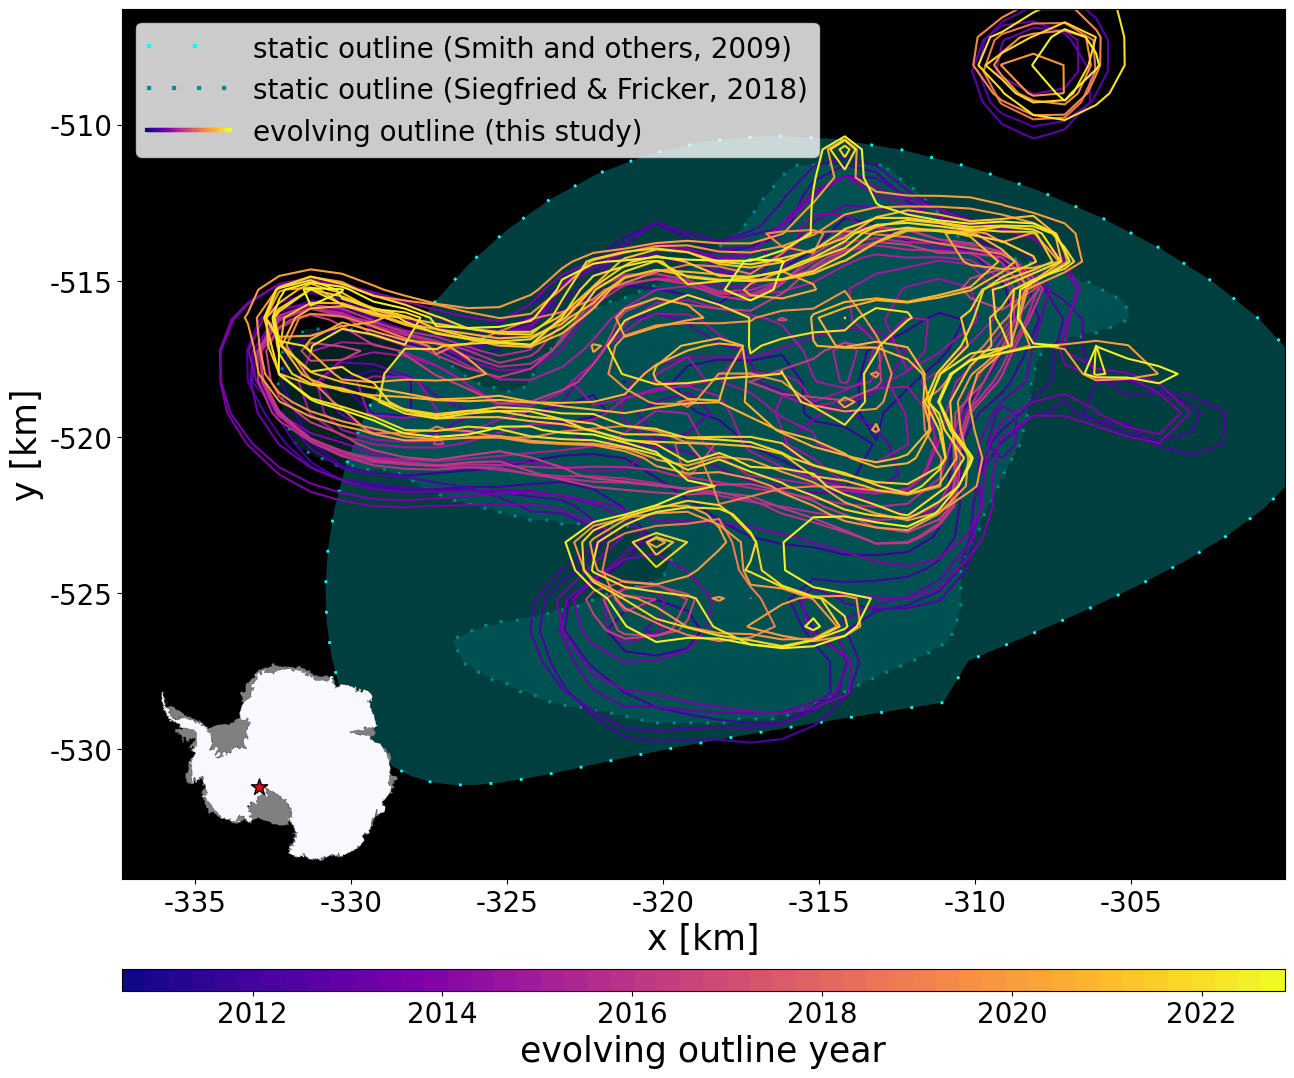

In [37]:
thresholds = [0.5]#, 0.4, 0.3, 0.2, 0.1]
for threshold in thresholds: 
    gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, CS2_dh, ATL15)
    plot_evolving_outlines_time_series(gdf, CS2_dh, ATL15)

In [38]:
gdf

,geometry,area (km^2),perim (km),dh (m),vol (km^3),datetime,centroid,date
0,"POLYGON ((-313162.835 -520120.366, -313692.037...",6.119540,11.656390,0.508910,3.114292,2011-08-17 06:45:00,POINT (-312330.681 -517706.451),2011-08-17
1,"POLYGON ((-328264.207 -519339.276, -329270.965...",2.451189,6.261419,0.504569,1.236795,2011-08-17 06:45:00,POINT (-329026.959 -518593.946),2011-08-17
2,"POLYGON ((-321216.900 -518271.001, -321256.925...",0.000895,0.135933,0.504569,0.000451,2011-08-17 06:45:00,POINT (-321225.249 -518252.498),2011-08-17
3,"POLYGON ((-314169.593 -521660.684, -315176.351...",13.611921,17.065133,0.504181,6.862867,2011-08-17 06:45:00,POINT (-316474.007 -519325.257),2011-08-17
4,"POLYGON ((-322223.658 -519361.054, -323230.417...",1.301126,5.910446,0.502310,0.653568,2011-08-17 06:45:00,POINT (-322990.228 -519207.367),2011-08-17
...,...,...,...,...,...,...,...,...
102,"POLYGON ((-330277.724 -515353.318, -331284.482...",0.397299,3.060506,0.189649,0.075347,2022-11-16 14:15:00,POINT (-330980.427 -515443.377),2022-11-16
103,"POLYGON ((-315176.351 -526204.082, -315438.481...",0.095887,1.274422,0.189649,0.018185,2022-11-16 14:15:00,POINT (-315192.675 -526035.592),2022-11-16
104,"POLYGON ((-306695.471 -508997.545, -306223.909...",4.649553,7.870432,-0.192057,-0.892977,2023-02-15 21:45:00,POINT (-307466.847 -507919.923),2023-02-15
105,"POLYGON ((-317120.662 -525183.082, -316272.130...",96.442815,46.124406,-0.192057,-18.522470,2023-02-15 21:45:00,POINT (-316744.018 -518978.200),2023-02-15


In [39]:
gdf_filtered = remove_outlier_polygon(gdf, axis='y', max_or_min='max')

Removed polygon with extreme max y-value at index 10.


In [50]:
gdf_filtered = remove_outlier_polygon(gdf_filtered, axis='y', max_or_min='max')

Removed polygon with extreme max y-value at index 61.


In [ ]:
plot_evolving_outlines_time_series(gdf_filtered, CS2_dh, ATL15)

In [54]:
gdf_cumulative = calculate_cumulative_metrics_by_date_to_gdf(gdf_filtered)
gdf_cumulative.head()

,date,cumulative_area,cumulative_dvol,weighted_cumulative_dh,combined_polygon
0,2011-08-17,23.484670,11.867974,0.505350,"MULTIPOLYGON (((-313162.835 -520120.366, -3136..."
1,2011-11-16,152.362461,92.558709,0.607490,"MULTIPOLYGON (((-312156.077 -523699.996, -3131..."
2,2012-02-15,241.191804,170.793350,0.708123,"MULTIPOLYGON (((-315176.351 -528673.528, -3161..."
3,2012-05-16,282.048038,211.078760,0.748379,"MULTIPOLYGON (((-315176.351 -529266.679, -3161..."
4,2012-08-16,275.165274,169.452326,0.615820,"MULTIPOLYGON (((-316183.109 -529207.713, -3171..."


In [ ]:
# Borrowed from KambIS_Horgan notebook

S09_color = 'cyan'
SF18_color  = 'darkcyan'

# # Try subsetting data first
# CS2_dh_sub = CS2_dh.sel(y=slice(y_max, y_min), x=slice(x_min, x_max))
# ATL15_dh_sub = ATL15.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))

# Define variables
# dataset1=CS2_dh_sub
# dataset2=ATL15_dh_sub
dataset1=CS2_dh
dataset2=ATL15
lake_name='ConwaySubglacialLake'

# Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
cyc_start_dates = []
cyc_end_dates = []
midcyc_dates = []
for idx in range(len(dataset1.delta_h[:33])):
    # Smith and others, 2017 method CryoSat-2 SARIn data
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
        cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
    # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product
    # ASSUMES THE SAME DATASET LENGTH, WHICH MIGHT NOT BE TRUE
    elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
        date_time_str = '70-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
        cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
for idx in range(len(dataset2.delta_h)-1): 
    # ICESat-2 ATL15 r003
    cyc_start_date = dataset2.time.values[idx]
    cyc_end_date = dataset2.time.values[idx+1]
    midcyc_days = cyc_end_date - cyc_start_date
    midcyc_date = cyc_start_date + midcyc_days/2
    midcyc_date = pd.to_datetime(midcyc_date)
    cyc_start_dates += [cyc_start_date]
    cyc_end_dates += [cyc_end_date]
    midcyc_dates += [midcyc_date]

outline09 = Smith2009_outlines[(Smith2009_outlines['Name'] == 'Whillans_4')]
outline18 = SiegfriedFricker2018_outlines[(SiegfriedFricker2018_outlines['name'] == lake_name)]
region = outline18['geometry'].buffer(10000)

# Clip CS2_dh to lake outline and region
dataset1.rio.write_crs("epsg:3031", inplace=True)
CS2_dh_outline = dataset1.rio.clip(outline18.geometry.values, outline18.crs)
CS2_dh_region = dataset1.rio.clip(region.geometry.values, region.crs)
CS2_dh_region = dataset1.rio.clip(outline18.geometry.values, outline18.crs, invert=True)

# Clip ATL15 to lake outline and region
dataset2.rio.write_crs("epsg:3031", inplace=True)
ATL15_outline = dataset2.rio.clip(outline18.geometry.values, outline18.crs)
ATL15_region = dataset2.rio.clip(region.geometry.values, region.crs)
ATL15_region = dataset2.rio.clip(outline18.geometry.values, outline18.crs, invert=True)

# Create empty lists to store calculated data
onlake_avgdhdts_SF18 = []
offlake_avgdhdts_SF18 = []
onlake_vols_SF18 = []
onlake_avgdhdts_SF18_corr = []

for idx in range(len(midcyc_dates)): 
    # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
    # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
    if idx <= 32:
        dhdt_onlake = CS2_dh_outline.delta_h[idx+1,:,:]-CS2_dh_outline.delta_h[idx,:,:]
        dhdt_offlake = CS2_dh_region.delta_h[idx+1,:,:]-CS2_dh_region.delta_h[idx,:,:]
        cyc_start_date = cyc_start_dates[idx]
        cyc_end_date = cyc_end_dates[idx]
        midcyc_date = midcyc_dates[idx]
    # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
    # This covers the ICESat-2 era (2018-11-16 to most recently available data)
    elif idx > 32:
        # Subtract 33 from idx to start over with new dataset
        dhdt_onlake = ATL15_outline.delta_h[(idx-33)+1,:,:]-ATL15_outline.delta_h[(idx-33),:,:]
        dhdt_offlake = ATL15_region.delta_h[(idx-33)+1,:,:]-ATL15_region.delta_h[(idx-33),:,:]
        cyc_start_date = cyc_start_dates[idx]
        cyc_end_date = cyc_end_dates[idx]
        midcyc_date = midcyc_dates[idx]

    # Calc areas and volumes
    onlake_avgdhdt_SF18 = np.nanmean(dhdt_onlake)
    offlake_avgdhdt_SF18 = np.nanmean(dhdt_offlake)
    onlake_avgdhdt_SF18_corr = onlake_avgdhdt_SF18 - offlake_avgdhdt_SF18
    onlake_avgdhdts_SF18 += [onlake_avgdhdt_SF18]
    offlake_avgdhdts_SF18 += [offlake_avgdhdt_SF18]
    onlake_avgdhdts_SF18_corr += [onlake_avgdhdt_SF18_corr]
    onlake_vol_SF18 = onlake_avgdhdt_SF18_corr*sum(outline.area)
    onlake_vols_SF18 += [onlake_vol_SF18]

# Plot figure - Area
fig, ax = plt.subplots(figsize=(10,10))

ax.plot([gdf_cumulative['date'].min(), gdf_cumulative['date'].max()], [outline09.area/1e6, outline09.area/1e6], color=S09_color, lw=5, linestyle=(0, (1, 3)), label='static outline (Smith and others, 2009)')
ax.plot([gdf_cumulative['date'].min(), gdf_cumulative['date'].max()], [outline18.area/1e6, outline18.area/1e6], color=SF18_color, lw=5, linestyle=(0, (1, 1)), label='static outline (Siegfried & Fricker, 2018)')
# ax.plot(gdf_cumulative['date'], gdf_cumulative['cumulative_area'], marker='o', label='evolving outlines (this study)')

# # Plot as points
# date_norm = (gdf_cumulative['date'] - gdf_cumulative['date'].min()) / (gdf_cumulative['date'].max() - gdf_cumulative['date'].min())
# cmap = plt.get_cmap('plasma')
# for i in range(len(gdf_cumulative['date'])):
#     # print(gdf_cumulative['date'][i])
#     # print(gdf_cumulative['cumulative_area'][i])
#     ax.plot(gdf_cumulative['date'][i], gdf_cumulative['cumulative_area'][i], color=cmap(date_norm.iloc[i]))

# # Plot as continuous line
# x=mdates.date2num(gdf_cumulative['date'])
# # x=gdf_cumulative['date']
# y=gdf_cumulative['cumulative_area']
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)
# # Create a continuous norm to map from data points to colors
# norm = plt.Normalize(x.min(), x.max())
# # norm = plt.Normalize(datetime2fracyear(x.min()), datetime2fracyear(x.max()))
# lc = LineCollection(segments, cmap='plasma', norm=norm)
# # Set the values used for colormapping
# lc.set_array(x)
# lc.set_linewidth(3)
# line = ax.add_collection(lc)

# # Make multicolored line segments for legend
# cmap = cm.get_cmap('plasma', len(gdf_cumulative['date']))
# # Use for loop to plot each outline in the geopandas dataframe and color by date
# lines = []  # list of lines to be used for the legend
# for idx, dt in enumerate(gdf_cumulative['date'], 0):
#     x = 1; y = 1
#     # line, = ax.plot(x, y, color=cmap(norm(datetime2fracyear(midcyc_dates[idx]))), linewidth=3)
#     line, = ax.plot(x, y, color=cmap(norm(mdates.date2num(midcyc_dates[idx]))), linewidth=3)
#     # FIXME: change midcyc_dates to gdf_cumulative['date']
#     lines.append(line)

ax.set_ylabel('lake area (km$^2$)', size=20)
ax.set_xlabel('year', size=20)
ax.set(xlim=(gdf_cumulative['date'].min(), gdf_cumulative['date'].max()), ylim=(0, 600))

Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=4)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)

# ax.legend([Smith2009,
#     SiegfriedFricker2018,
#     tuple(lines)],
#     ['static outline (Smith and others, 2009)',
#     'static outline (Siegfried & Fricker, 2018)',
#     'evolving outlines (this study)'],
#     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     bbox_to_anchor=(0.1, 1), loc='upper left')

plt.show()


# # Plot figure - dhdt
# fig, ax = plt.subplots(figsize=(5,5))

# ax.plot(midcyc_dates, np.cumsum(onlake_avgdhdts_SF18_corr), color='k', linestyle='dotted', linewidth=2.5)
# ax.scatter(midcyc_dates, np.cumsum(onlake_avgdhdts_SF18_corr), color='k', label='on lake')
# ax.plot(midcyc_dates, np.cumsum(onlake_avgdhdts_SF18), color='blue', linestyle='dotted', linewidth=2.5)
# ax.scatter(midcyc_dates, np.cumsum(onlake_avgdhdts_SF18), color='blue', label='on lake (no. corr)')
# ax.plot(midcyc_dates, np.cumsum(offlake_avgdhdts_SF18), color='red', linestyle='dotted', linewidth=2.5)
# ax.scatter(midcyc_dates, np.cumsum(offlake_avgdhdts_SF18), color='red', label='off lake')
# ax.set_ylabel('average height change [m]', size=17.5)

# plt.show()


# # Plot figure - dVol
# fig, ax = plt.subplots(figsize=(5,5))

# ax.plot(midcyc_dates, np.divide(np.cumsum(onlake_vols_SF18), 1e9), color='k', linestyle='dotted', linewidth=2.5)
# ax.scatter(midcyc_dates, np.divide(np.cumsum(onlake_vols_SF18), 1e9), color='k')
# ax.set_ylabel('volume change [km$^3$]', size=17.5)

# ax.legend(loc='upper right')

# # fig.suptitle('{} $\Delta$Height and $\Delta$Volume'.format(lake_name), fontsize=30)

# plt.show()

In [ ]:
plot_evolving_outlines_dArea(ROI, gdf, CS2_dh, ATL15)

In [ ]:
threshold = 0.5 #, 0.4, 0.3, 0.2, 0.1]
gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, CS2_dh, ATL15_dh)

In [ ]:
plot_evolving_outlines_time_series(gdf)

In [ ]:
gdf_overlapping = find_overlapping_polygons(gdf)

In [ ]:
plot_evolving_outlines_time_series(gdf_overlapping)

In [ ]:
gdf_filtered = remove_outlier_polygon(gdf_overlapping, 'x', 'min')

In [ ]:
plot_evolving_outlines_time_series(gdf_filtered)

In [ ]:
gdf_filtered = remove_outlier_polygon(gdf_filtered, 'x', 'max')

In [ ]:
plot_evolving_outlines_time_series(gdf_filtered)

In [ ]:
create_dirs(['csv_export'], OUTPUT_DIR)

In [ ]:
csv_export(ROI, gdf_filtered)

In [ ]:
create_dirs(['plot_evolving_outlines_dArea'], OUTPUT_DIR)

In [ ]:
plot_evolving_outlines_dArea(ROI, gdf_filtered)

In [ ]:
ROI = 'Whillans_7'  #Sauthoff2023_outlines['name'][0]
buffer = 5000
x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)
dataset1 = CS2_dh
dataset2 = ATL15_dh

In [ ]:
threshold = 0.5
gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
plot_evolving_outlines_time_series(gdf, dataset1, dataset2)

In [ ]:
buffer = 5000
dataset1 = CS2_dh
dataset2 = ATL15_dh

for ROI in Sauthoff2023_outlines['name']: 
    find_bbox_coords_n_clip(ROI, buffer, dataset1, dataset2)

In [ ]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
threshold = 0.1
dataset1 = CS2_dh
dataset2 = ATL15_dh
start_idx = Sauthoff2023_outlines[Sauthoff2023_outlines['name'] == 'TL115'].index.values[0]

for idx in range(start_idx, len(Sauthoff2023_outlines)):
    ROI = Sauthoff2023_outlines['name'][idx]
    x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

    gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
    plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
    plt.close()

In [ ]:
# trying quadrants

In [ ]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
# threshold = 0.5
thresholds = [0.1, 0.2, 0.3, 0.4]#, 0.5]
dataset1 = CS2_dh
dataset2 = ATL15_dh_A1

for index, row in Sauthoff2023_outlines.iterrows():   
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the forth quadrant of polar stereographic projection
    if x_coord >= 0 and y_coord >= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        print(ROI)
        x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

        for threshold in thresholds:
            gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
            plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
            plt.close()

In [24]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
threshold = 0.1
dataset1 = CS2_dh
dataset2 = ATL15_dh_A2
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
thresholds = [0.2, 0.3, 0.4, 0.5]

for index, row in Sauthoff2023_outlines.iterrows():   
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the second quadrant of polar stereographic projection
    if x_coord <= 0 and y_coord >= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        print(ROI)
#         x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

#         for threshold in thresholds:
#             gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
#             plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
#             plt.close()

Foundation_1
Foundation_10
Foundation_11
Foundation_12
Foundation_13
Foundation_14
Foundation_15
Foundation_16
Foundation_2
Foundation_3
Foundation_4
Foundation_5
Foundation_6
Foundation_7
Foundation_8
Foundation_9
Foundation_N1
Foundation_N2
Foundation_N3
Institute_E1
Institute_E2
Institute_W1
Institute_W2
Rec1
Rec2
Rec3
Rec4
Rec5
Rec6
Recovery_8
Rutford_1
Slessor_1
Slessor_23
Slessor_4
Slessor_5
Slessor_6
Slessor_7


In [22]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
thresholds = [0.2, 0.3, 0.4, 0.5]
dataset1 = CS2_dh
dataset2 = ATL15_dh_A2

for index, row in Sauthoff2023_outlines.iterrows():   
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the second quadrant of polar stereographic projection
    if x_coord <= 0 and y_coord >= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        if ROI not in ['Foundation_1',
            'Foundation_10',
            'Foundation_11',
            'Foundation_12',
            'Foundation_13',
            'Foundation_14',
            'Foundation_15',
            'Foundation_16',
            'Foundation_2',
            'Foundation_3',
            'Foundation_4',
            'Foundation_5',
            'Foundation_6',
            'Foundation_7',
            'Foundation_8',
            'Foundation_9',
            'Foundation_N1',
            'Foundation_N2',
            'Foundation_N3',
            'Institute_E1',
            'Institute_E2',
            'Institute_W1',
            'Institute_W2',
            'Rec1',
            'Rec2',
            'Rec3',
            'Rec4',
            'Rec5',
            'Rec6',
            'Recovery_8',
            'Rutford_1',
            'Slessor_1']:
            print(ROI)
            x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

            for threshold in thresholds:
                gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
                plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
                plt.close()

Slessor_23
Slessor_4
Slessor_5
Slessor_6
Slessor_7


In [22]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
thresholds = [0.2, 0.3, 0.4, 0.5]
dataset1 = CS2_dh
dataset2 = ATL15_dh_A3

for index, row in Sauthoff2023_outlines.iterrows():   
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the third quadrant of polar stereographic projection
    if x_coord <= 0 and y_coord <= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        print(ROI)
#         x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

#         for threshold in thresholds:
#             gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
#             plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
#             plt.close()

Bindschadler_1
Bindschadler_2
Bindschadler_3
Bindschadler_4
Bindschadler_5
Bindschadler_6
ConwaySubglacialLake
EngelhardtSubglacialLake
KT1
KT2
KT3
Kamb_1
Kamb_10
Kamb_11
Kamb_12
Kamb_2
Kamb_3
Kamb_4
Kamb_5
Kamb_6
Kamb_7
Kamb_8
Kamb_9
Lake10
Lake12
Lake78
LowerMercerSubglacialLake
LowerSubglacialLakeConway
Mac1
Mac2
Mac3
Mac4
Mac5
Mac6
Mac7
Mac8
MercerSubglacialLake
Raymond_1
TL108
TL115
TL122
TL96
Thw_124
Thw_142
Thw_170
Thw_70
UpperSubglacialLakeConway
WT
WhillansSubglacialLake
Whillans_6
Whillans_7
Whillans_8


In [38]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
thresholds = [0.3, 0.4, 0.5]
dataset1 = CS2_dh
dataset2 = ATL15_dh_A3

for index, row in Sauthoff2023_outlines[Sauthoff2023_outlines['name'] == 'Whillans_6'].iterrows():  
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the third quadrant of polar stereographic projection
    if x_coord <= 0 and y_coord <= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        print(ROI)
        x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

        for threshold in thresholds:
            gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
            plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
            plt.close()

Whillans_6


In [ ]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
# thresholds = [0.2, 0.3, 0.4, 0.5]
dataset1 = CS2_dh
dataset2 = ATL15_dh_A3

for index, row in Sauthoff2023_outlines.iterrows():   
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the third quadrant of polar stereographic projection
    if x_coord <= 0 and y_coord <= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        if ROI not in ['Bindschadler_1',
            'Bindschadler_2',
            'Bindschadler_3',
            'Bindschadler_4',
            'Bindschadler_5',
            'Bindschadler_6',
            'ConwaySubglacialLake',
            'EngelhardtSubglacialLake',
            'KT1',
            'KT2',
            'KT3',
            'Kamb_1',
            'Kamb_10',
            'Kamb_11',
            'Kamb_12',
            'Kamb_2',
            'Kamb_3',
            'Kamb_4',
            'Kamb_5',
            'Kamb_6',
            'Kamb_7',
            'Kamb_8',
            'Kamb_9',
            'Lake10',
            'Lake12',
            'Lake78',
            'LowerMercerSubglacialLake',
            'LowerSubglacialLakeConway',
            'Mac1',
            'Mac2',
            'Mac3',
            'Mac4',
            'Mac5',
            'Mac6',
            'Mac7',
            'Mac8',
            'MercerSubglacialLake',
            'Raymond_1',
            'TL108',
            'TL115',
            'TL122',
            'TL96',
            'Thw_124',
            'Thw_142',
            'Thw_170',
            'Thw_70',
            'UpperSubglacialLakeConway',
            'WT',
            'WhillansSubglacialLake',
            'Whillans_6',
            'Whillans_7']:
            print(ROI)
            x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

            for threshold in thresholds:
                gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
                plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
                plt.close()

Whillans_8


In [38]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
thresholds = [0.2, 0.3, 0.4, 0.5]
dataset1 = CS2_dh
dataset2 = ATL15_dh_A4

for index, row in Sauthoff2023_outlines.iterrows():   
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the forth quadrant of polar stereographic projection
    if x_coord >= 0 and y_coord <= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        print(ROI)
#         x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

#         for threshold in thresholds:
#             gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
#             plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
#             plt.close()

Byrd_1
Byrd_2
Byrd_s1
Byrd_s10
Byrd_s11
Byrd_s12
Byrd_s13
Byrd_s14
Byrd_s15
Byrd_s2
Byrd_s3
Byrd_s4
Byrd_s5
Byrd_s6
Byrd_s7
Byrd_s8
Byrd_s9
Cook_E1
Cook_E2
David_1
David_s1
David_s2
David_s3
David_s4
David_s5
EAP_1
EAP_2
EAP_3
EAP_4
EAP_5
EAP_6
EAP_7
EAP_8
EAP_9
L1
LennoxKing_1
Mertz_1
Mulock_1
Nimrod_1
Nimrod_2
Ninnis_1
Ninnis_2
Totten_1
Totten_2
U1
U2
U3
Vostok_1
Wilkes_1
Wilkes_2
“Site A”
“Site B”
“Site C”


In [38]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
thresholds = [0.3, 0.4, 0.5]
# thresholds = [0.1]
dataset1 = CS2_dh
dataset2 = ATL15_dh_A4

for index, row in Sauthoff2023_outlines[Sauthoff2023_outlines['name'] == '“Site A”'].iterrows():  
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the third quadrant of polar stereographic projection
    if x_coord >= 0 and y_coord <= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        print(ROI)
        x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

        for threshold in thresholds:
            gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
            plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
            plt.close()

“Site A”


In [41]:
# First plot evolving all previously identified lakes (collated in Sauthoff and others, 2024 inventory)
# Start with horizontal buffer of 5 km and height change threshold of 0.1 m (similar to Smith and others, 2009, JoG)

buffer = 5000
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
# thresholds = [0.2, 0.3, 0.4, 0.5]
dataset1 = CS2_dh
dataset2 = ATL15_dh_A4
    
for index, row in Sauthoff2023_outlines.iterrows():   
    centroid = row['geometry'].centroid
    x_coord = centroid.x
    y_coord = centroid.y

    # Check if both x and y coordinates are in the forth quadrant of polar stereographic projection
    if x_coord >= 0 and y_coord <= 0:
        ROI = Sauthoff2023_outlines['name'][index]
        if ROI not in ['Byrd_1',
            'Byrd_2',
            'Byrd_s1',
            'Byrd_s11',
            'Byrd_s10',
            'Byrd_s12',
            'Byrd_s13',
            'Byrd_s14',
            'Byrd_s15',
            'Byrd_s2',
            'Byrd_s3',
            'Byrd_s4',
            'Byrd_s5',
            'Byrd_s6',
            'Byrd_s7',
            'Byrd_s8',
            'Byrd_s9',
            'Cook_E2',
            'Cook_E1',
            'David_1',
            'David_s1',
            'David_s2',
            'David_s3',
            'David_s4',
            'David_s5',
            'EAP_1',
            'EAP_2',
            'EAP_3',
            'EAP_4',
            'EAP_5',
            'EAP_6',
            'EAP_7',
            'EAP_8',
            'EAP_9',
            'L1',
            'LennoxKing_1',
            'Mertz_1',
            'Mulock_1',
            'Nimrod_1',
            'Nimrod_2',
            'Ninnis_1',
            'Ninnis_2',
            'Totten_1',
            'Totten_2',
            'U1',
            'U2',
            'U3',
            'Vostok_1',
            'Wilkes_1',
            'Wilkes_2',
            '“Site A”'
            ]:
            print(ROI)
            x_min, x_max, y_min, y_max =  find_bbox_coords(ROI, buffer)

            for threshold in thresholds:
                gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)
                plot_evolving_outlines_time_series(gdf, dataset1, dataset2)
                plt.close()

“Site B”
“Site C”


In [ ]:
ROIs_10km_buffer_point1m_threshold = ['Byrd_2', 
    'Byrd_s2',
    'Byrd_s10',
    'Byrd_s13',
    'Byrd_s14',
    'Byrd_s4',
    'Byrd_s5',
    'Byrd_s6',
    'Byrd_s7',
    'Byrd_s8',        
    'Byrd_s9',
    'David_s1',
    'David_s3',
    'David_s4',
    'EAP_2',
    'EngelhardtSubglacialLake',
    'Foundation_1',
    'Foundation_11',
    'Foundation_12',
    'Foundation_13',
    'Foundation_14',
    'Foundation_15',
    'Foundation_3',
    'Foundation_4',
    'Foundation_5',
    'Foundation_6',
    'Foundation_7',
    'Foundation_8',
    'Foundation_9',
    'Foundation_N2',
    'Lake12',
    'Mac5',
    'Mulock_1',
    'Nimrod_2',
    'Rec10',
    'Rec3',
    'Rec4',
    'Rec5',
    'Rec6',
    'Recovery_8',
                                      
ROIs_10km_buffer_point2m_threshold = ['Slessor_23',
    'Slessor_4',
    'Slessor_7',

ROIs_point2m_threshold = ['Bindschadler_2', 
    'Bindschadler_3', 
    'Bindschadler_4,
    'Bindschadler_5',
    'Bindschadler_6',
    'Byrd_1',
    'Byrd_s11',
    'Byrd_s12',
    'Byrd_s2',
    'Byrd_s3',
    'Byrd_s4',
    'Byrd_s5',
    'Byrd_s6',
    'Byrd_s7',
    'Byrd_s8'
    'Byrd_s9', 
    'ConwaySubglacialLake',
    'Cook_E1',
    'Cook_E2',
    'David_1',
    'David_s1',
    'David_s2',
    'David_s3',
    'David_s4',
    'David_s5',
    'EngelhardtSubglacialLake',
    'Foundation_1',
    'Foundation_10',
    'Foundation_11',
    'Foundation_12',
    'Foundation_2',
    'Foundation_3',
    'Foundation_4',
    'Foundation_5',
    'Foundation_N1',
    'Foundation_N3',
    'Institute_E1',
    'Institute_E2',
    'Institute_W1',
    'Institute_W2',
    'Kamb_1',
    'Kamb_10',
    'Kamb_11',
    'Kamb_12',
    'Kamb_2',
    'Kamb_3',
    'Kamb_4',
    'Kamb_5',
    'Kamb_6',
    'Kamb_7',
    'Kamb_8',
    'Kamb_9',
    'KT1',
    'KT2',
    'KT3',
    'Lake10',
    'Lake78',
    'Lambert_1',
    'LennoxKing_1',
    'LowerMercerSubglacialLake',
    'LowerSubglacialLakeConway',
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Mac6',
    'Mac7',
    'Mac8',
    'MercerSubglacialLake',
    'Mertz_1',
    'Ninnis_1',
    'Ninnis_2',
    'Raymond_1',
    'Rec1',
    'Rec2',
    'Rec3',
    'Rec6',
    'Rutford_1',
    'Slessor_1',
    'Slessor_6',
    'Thw_124',
    'Thw_142',
    'Thw_170',
    'Thw_70',
    'TL108',
                          
    'Totten_1',


ROIs_point05m_threshold = ['Rec8',
    'Rec9',         
# look for ones you didn't add initially

# Scrap code

In [ ]:
# Editing to stitch CS2 and IS2 data together

thres=0.5
dataset1=CS2_dh
dataset2=ATL15_dh

lake_S09 = Smith2009_outlines[(Smith2009_outlines['Name'] == 'Whillans_7')]
lake_SF18 = SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == 'Whillans_7']
S09_color = 'lightseagreen'
SF18_color = 'teal'

# Manually set because of new lake lobe
x_min = -560e3; x_max = -525e3
y_min = -512e3; y_max = -494e3

# Subset dataset and MOA imagery to region of interest using data masks
mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
ds_sub1 = dataset1.where(mask_x & mask_y, drop=True)
mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
ds_sub2 = dataset2.where(mask_x & mask_y, drop=True)
# mask_x = (moa_highres_da.x >= x_min) & (moa_highres_da.x <= x_max)
# mask_y = (moa_highres_da.y >= y_min) & (moa_highres_da.y <= y_max)
# moa_highres_da_sub = moa_highres_da.where(mask_x & mask_y, drop=True)

# Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
cyc_start_dates = []
cyc_end_dates = []
midcyc_dates = []
for idx in range(len(dataset1.delta_h[:33])):
    # Smith and others, 2017 method CryoSat-2 SARIn data
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
        cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
    # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product 
    elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
        date_time_str = '70-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
        cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
for idx in range(len(dataset2.delta_h)-1): 
    # ICESat-2 ATL15 r003
    if dataset2.identifier_product_DOI == 'NOT_SET':    
        date_time_str = '18-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        cyc_start_date = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
        cyc_end_date = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
        
# Pick colormap and make continuous cmap discrete
cmap = cm.get_cmap('plasma', len(midcyc_dates)-1)
# Norm to time variable
norm = plt.Normalize(ds_sub1.time.values[0], ds_sub2.time.values[-1])

# Plot figure
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(10,5))#, gridspec_kw={'width_ratios': [2, 1, 1], 'height_ratios': [1]})

# Overlay published active lake outlines for visual comparison
Smith2009_outlines.boundary.plot(ax=axs[0], facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
Smith2009_outlines.boundary.plot(ax=axs[0], edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axs[0], facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axs[0], edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=axs[0], facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
Sauthoff2023_S23outlines.boundary.plot(ax=axs[0], edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)

# Set axes limits
axs[0].set(#xticks=[], yticks=[], 
           xlim=(x_min, x_max), ylim=(y_min, y_max))

# Change polar stereographic m to km for cleaner-looking axes
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axs[0].xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axs[0].yaxis.set_major_formatter(ticks_y)  

# Label axes
axs[0].set_xlabel('x [km]', size=20)
axs[0].set_ylabel('y [km]', size=20)

# Create lines for legend
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 5)), linewidth=4)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)
uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=3)
subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=3)

# Plot inset map to show location 
axIns = axs[0].inset_axes([0.72, 0.68, 0.5, 0.5]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1) 
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=150, zorder=3)
axIns.axis('off')

# Create colorbar 
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([datetime2fracyear(date) for date in midcyc_dates[0:]]))
cax = inset_axes(axs[0],
                    width="100%",  
                    height="10%",
                    loc='lower center',
                    borderpad=-7
                   )
fig.colorbar(m, cax=cax, orientation='horizontal').set_label('Variable lake outline year', size=15)

# Create empty lists to store calculated data
lkavgdhdt_S09 = []
lkavgdhdt_SF18 = []
lkavgdhdt_var = []
areas_var = []
vols_S09 = []
vols_SF18 = []
vols_var = []

for idx in range(len(midcyc_dates)-1):
    # Stitch together CryoSat-2 and ICESat-2 time series
    if idx <= 32:
        dhdt = ds1_clipped.delta_h[idx+1,:,:]-ds_sub1.delta_h[idx,:,:]
    elif idx > 32:
        dhdt = ds2_clipped.delta_h[(idx-33)+1,:,:]-ds_sub2.delta_h[(idx-33),:,:]

    # Clip dh/dt to published static outlines
    dhdt.rio.write_crs(3031, inplace=True)
    dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
    dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)

    # Calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
    avg_lk_dhdt_S09 = np.nanmean(dhdt_clip_S09)
    avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
    lkavgdhdt_S09 += [avg_lk_dhdt_S09]
    lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
    vol_S09 = avg_lk_dhdt_S09*sum(lake_S09.area) # FIXME: change to geodesic area
    vol_SF18 = avg_lk_dhdt_SF18*sum(lake_SF18.area)
    vols_S09 += [vol_S09]
    vols_SF18 += [vol_SF18]

    # Create contours of ice surface elevation height changes to delineate lake outlines
    contours_fill = []
    contours_drain = []
    polys = []
    contour = measure.find_contours(dhdt.values, thres)
    if len(contour) > 0: 
        contours_fill += [contour]
    contour = measure.find_contours(dhdt.values, -thres)
    if len(contour) > 0: 
        contours_drain += [contour]

    # Create mapping conversion factor to map array location to polar stereographic x,y
    x_conv = (x_max-x_min)/dhdt.shape[1]
    y_conv = (y_max-y_min)/dhdt.shape[0]

    # Plot and make polygons from variable outlines
    for i in range(len(contours_fill)): 
        for j in range(len(contours_fill[i])):
            if len(contours_fill[i][j][:, 1]) > 2: 
                axs[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                    # color=cmap(norm(midcyc_dates[idx])), 
                    linestyle=(0, (3, 1, 1, 1)), linewidth=1, zorder=3)
                poly = Polygon(list(zip(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv)))
                polys += [poly]
    for i in range(len(contours_drain)): 
        for j in range(len(contours_drain[i])):
            if len(contours_drain[i][j][:, 1]) > 2: 
                axs[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                    # color=cmap(norm(midcyc_dates[idx])), 
                    linestyle=(0, (5, 1)), linewidth=1, zorder=3)
                poly = Polygon(list(zip(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                polys += [poly]

    # Start with baseline variable outline area of zero
    area_var = 0
    # If polygons are present at time step, 
    if len(polys) > 0: 
        # Clip data to polygons 
        dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
        # Then calculate on-lake averages of dh/dt
        avg_lk_dhdt = np.nanmean(dhdt_clip)
        # Occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
        # eplace with zeros
        if math.isnan(avg_lk_dhdt): 
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
        else:
            lkavgdhdt_var += [avg_lk_dhdt]                
        # and dv/dt
        for i in range(len(polys)):
            area_var = area_var + polys[i].area # TODO: CHANGE TO GEODESIC AREA
        # Store areas in list 
        areas_var += [area_var]
        # Calculate and store volumes in list
        vol_var = avg_lk_dhdt*area_var
        vols_var += [vol_var]
    else: 
        # Store areas in list 
        areas_var += [area_var]
        # Set lake dhdt to zero because no variable outline polygons
        avg_lk_dhdt = 0
        # Store dhdt's in list 
        lkavgdhdt_var += [avg_lk_dhdt]
        # Calculate variable volumes
        vol_var = avg_lk_dhdt*area_var
        # Store variable volumes in list
        vols_var += [vol_var]

# Calculate bias
# S09_var_dh_bias = [a_i - b_i for a_i, b_i in zip(lkavgdhdt_var, lkavgdhdt_S09)]
# S09_var_vol_bias = [a_i - b_i for a_i, b_i in zip(np.cumsum(vols_var), np.cumsum(vols_S09))]

# Plot 1 - plot area change time series
axs[1].axhline(np.divide(sum(lake_S09.area), 1e6), color=S09_color, linestyle=(0, (1, 5)))
axs[1].plot(midcyc_dates[:idx+1], np.divide(areas_var[:idx+1], 1e6), color='k', linestyle='solid')
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)
min_area = min(np.divide(sum(lake_S09.area), 1e6), 
                np.divide(sum(lake_SF18.area), 1e6), 
                min(np.divide(np.cumsum(areas_var),1e6)))
max_area = max(np.divide(sum(lake_S09.area), 1e6), 
                np.divide(sum(lake_SF18.area), 1e6), 
                max(np.divide(np.cumsum(areas_var),1e6)))
axs[1].set(ylim=((min_area - (max_area - min_area)*0.05), (max_area + (max_area - min_area)*0.05)))
axs[1].set_ylabel('area [km$^2$]', size=17.5, labelpad=4)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
variable_outlines = plt.Line2D((0, 1), (0, 0), color='k', linestyle='solid', linewidth=3)
legend2 = axs[1].legend([Smith2009,
    #SiegfriedFricker2018,
    variable_outlines],
                ['static outline',
    #'Siegfried & Fricker, 2018 static outline',
    # '±{} m variable outlines'.format(thres)], 
    'variable outlines'],
    loc='upper right')
legend2.get_frame().set_linewidth(0.0)
axs[1].patch.set_alpha(1)

# # Plot 2 - height change time series
# axs[2].plot(midcyc_dates[:-1], lkavgdhdt_S09, color=S09_color, linestyle=(0, (1, 5)))
# axs[2].plot(midcyc_dates[:-1], lkavgdhdt_var, color='k', linestyle='solid')
# axs[2].plot(midcyc_dates[:-1], S09_var_dh_bias, color='r', linestyle='solid')
# locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
# formatter = mdates.ConciseDateFormatter(locator)
# axs[2].xaxis.set_major_locator(locator)
# axs[2].xaxis.set_major_formatter(formatter)
# axs[2].set_xlabel('year', size=17.5)
# axs[2].set_ylabel('height change [m]', size=17.5, labelpad=5)
# axs[2].yaxis.tick_right()
# axs[2].yaxis.set_label_position("right")
# bias = plt.Line2D((0, 1), (0, 0), color='r', linestyle='solid', linewidth=3)
# legend = axs[2].legend([#Smith2009,
#     #SiegfriedFricker2018,
#     bias],
#                 [#'static outline',
#     #'Siegfried & Fricker, 2018 static outline',
#     # '±{} m variable outlines'.format(thres)], 
#     'bias'],
#     loc='lower right')
# legend.get_frame().set_linewidth(0.0)
# axs[2].patch.set_alpha(1)

# # Plot 3 - volume change time series
# axs[3].plot(midcyc_dates[:-1], np.divide(np.cumsum(vols_S09), 1e+9), color=S09_color, linestyle=(0, (1, 5)))
# axs[3].plot(midcyc_dates[:-1], np.divide(np.cumsum(vols_var), 1e+9), color='k', linestyle='solid')
# axs[3].plot(midcyc_dates[:-1], np.divide(S09_var_vol_bias, 1e+9), color='r', linestyle='solid')
# locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
# formatter = mdates.ConciseDateFormatter(locator)
# axs[3].xaxis.set_major_locator(locator)
# axs[3].xaxis.set_major_formatter(formatter)
# min_vol = min(np.divide(min(np.cumsum(vols_S09)), 1e+9), 
#             #   np.divide(min(np.cumsum(vols_SF18)), 1e+9), 
#                 np.divide(min(np.cumsum(vols_var)), 1e+9))
# max_vol = max(np.divide(max(np.cumsum(vols_S09)), 1e+9), 
#             #   np.divide(max(np.cumsum(vols_SF18)), 1e+9), 
#                 np.divide(max(np.cumsum(vols_var)), 1e+9))

# axs[3].set(xlim=(midcyc_dates[0], midcyc_dates[-1]), 
#             ylim=((min_vol - (max_vol - min_vol)*0.05),
#                     (max_vol + (max_vol - min_vol)*0.05)))
# axs[3].set_xlabel('year', size=17.5)
# axs[3].set_ylabel('vol. change [km$^3$]', size=17.5, labelpad=0)
# axs[3].yaxis.tick_right()
# axs[3].yaxis.set_label_position("right")
# axs[3].patch.set_alpha(1)

# Save and close figure
# plt.savefig('/Users/Wilson/Documents/0-code/output/output_S09SF18varoutlines-visual-imagery/S09SF18varoutlines_agg_moa_plot/regions/S09SF18varoutlines_agg_moa_plot-{}-{}.png'.format(region_name,dataset.Title), dpi=300, bbox_inches = "tight") # change to name after region name given as func input?
# plt.close()
plt.show()

In [ ]:
# TODO
# (left) colormap of outlines not matching colorbar
# (right) fix y axis bounds on da/dt plot